In [2]:
!pip install category-encoders --quiet
!pip install category-encoders --quiet
!pip install h3 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder

from geopy.distance import great_circle
from catboost import CatBoostRegressor
import h3

import os
import matplotlib.pyplot as plt
import seaborn as sns
import json

my_seed = 59

In [4]:
def read_concatenated_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read().strip()
    
    json_objects = content.split('}{')
    
    json_objects = [obj + '}' if i != len(json_objects) - 1 else obj for i, obj in enumerate(json_objects)]
    json_objects = ['{' + obj if i != 0 else obj for i, obj in enumerate(json_objects)]
    
    data = []
    for obj in json_objects:
        try:
            data.append(json.loads(obj))
        except json.JSONDecodeError as e:
            print(f"Failed to parse: {obj}\nError: {e}")
    
    return data

In [5]:
json_path = '/kaggle/input/cian-moscow-big-wprices/offers_moscow_wprices.json'

list_of_dicts = read_concatenated_json(json_path)
print(f'Parsed {len(list_of_dicts)} deals.')

Parsed 17249 deals.


In [6]:
def filter_none_keys(data_dict):
    clear_dict = {}
    for k, v in data_dict.items():
        if type(v) in [bool, dict, int, list] or (v and v.strip()):
            clear_dict[k] = v
    return clear_dict

In [7]:
i = 0
print(filter_none_keys(list_of_dicts[i]).keys())

dict_keys(['isByHomeowner', 'isRentByParts', 'isStandard', 'newbuilding', 'repairType', 'hasFurniture', 'isApartments', 'exportPdfLink', 'geo', 'specialty', 'platform', 'combinedWcsCount', 'isFairplay', 'villageMortgageAllowed', 'isAuction', 'floorNumber', 'demolishedInMoscowProgramm', 'exportDocLink', 'flatType', 'gaObjectType', 'isCianPartner', 'status', 'isExcludedFromAction', 'addedTimestamp', 'isPremium', 'dealType', 'livingArea', 'basicProfiScore', 'id', 'category', 'publishTerms', 'isImported', 'windowsViewType', 'descriptionMinhash', 'callTrackingProvider', 'balconiesCount', 'editDate', 'offerType', 'isMulti', 'isEnabledCallTracking', 'objectType', 'separateWcsCount', 'fromDeveloper', 'hasRamp', 'fullUrl', 'building', 'cianUserId', 'publishedUserId', 'kitchenArea', 'isColorized', 'isNeedHideExactAddress', 'added', 'description', 'isTop3', 'objectGuid', 'isRecidivist', 'isInHiddenBase', 'roomsCount', 'cianId', 'totalArea', 'loggiasCount', 'userId', 'hasLift', 'bargainTerms', 'fl

In [8]:
# X: dealType, roomsCount, repairType, hasFurniture, isApartments, floorNumber, flatType, livingArea, windowsViewType, balconiesCount, building['buildYear'], building['materialType'], 
#    kitchenArea, isRecidivist, roomsCount, totalArea, hasLift, geo['coordinates']['lat', 'lng'], len(geo['highways']), len(geo['undergrounds']), len(geo['railways']),
#    moscow_center = 55.75277384912519, 37.62316870851314
    
# Y: bargainTerms['price']

# for k in list_of_dicts[0].keys():
#     print(k)

# matching_keys = [key for key in list_of_dicts[i] if 'price' in key.lower()]
# matching_keys

# for k in matching_keys:
#     print(f'{k} :\t {list_of_dicts[i][k]}')

In [9]:
def get_usefull_data(data_dict, selected_keys):
    new_data = {}
    
    for sk in selected_keys:
        if sk not in ['geo', 'building', 'bargainTerms']:
            new_data[sk] = data_dict.get(sk, np.nan)

    # nested values proc by hand
    if 'building' in selected_keys:
        building = data_dict['building']
        new_data['buildYear'] = building.get('buildYear', np.nan)
        new_data['materialType'] = building.get('materialType', np.nan)
        
    if 'geo' in selected_keys and 'geo' in data_dict:
        geo = data_dict['geo']
        try:
            lat = geo['coordinates']['lat']
            lng = geo['coordinates']['lng']
            city_center = (55.752773, 37.623168)
            distance = great_circle((lat, lng), city_center).km
            new_data['distance_to_center'] = distance
        except (KeyError, TypeError):
            new_data['distance_to_center'] = np.nan
        
        for feature in ['highways', 'undergrounds', 'railways']:
            count = len(geo.get(feature, []))
            new_data[f'{feature}_count'] = count

    if 'bargainTerms' in selected_keys:
        new_data['price'] = data_dict['bargainTerms']['price']

    return new_data
        

In [10]:
selected_keys = ['geo', 'dealType', 'roomsCount', 'repairType', 'hasFurniture', 'isApartments', 'floorNumber', 'flatType', 'livingArea', 'windowsViewType', 
                 'balconiesCount', 'building', 'kitchenArea', 'isRecidivist', 'roomsCount', 'totalArea', 'hasLift', 'bargainTerms']
get_usefull_data(filter_none_keys(list_of_dicts[0]), selected_keys)

{'dealType': 'sale',
 'roomsCount': 5,
 'repairType': 'euro',
 'hasFurniture': False,
 'isApartments': False,
 'floorNumber': 3,
 'flatType': 'rooms',
 'livingArea': '170.0',
 'windowsViewType': 'yardAndStreet',
 'balconiesCount': 1,
 'kitchenArea': '20.0',
 'isRecidivist': False,
 'totalArea': '210.0',
 'hasLift': True,
 'buildYear': 1915,
 'materialType': 'brick',
 'distance_to_center': 1.816217364290418,
 'highways_count': 0,
 'undergrounds_count': 7,
 'railways_count': 6,
 'price': 200000000.0}

In [11]:
clear_data = [get_usefull_data(filter_none_keys(data_dict), selected_keys) for data_dict in list_of_dicts]
print(len(clear_data))

17249


In [12]:
ds_full = pd.DataFrame(clear_data)
print(ds_full.head())

  dealType  roomsCount repairType hasFurniture isApartments  floorNumber  \
0     sale           5       euro        False        False            3   
1     sale           1   cosmetic          NaN        False            4   
2     sale           3     design          NaN        False           23   
3     sale           2       euro         True          NaN            5   
4     sale           1   cosmetic         True        False            6   

  flatType livingArea windowsViewType  balconiesCount  ... isRecidivist  \
0    rooms      170.0   yardAndStreet             1.0  ...        False   
1    rooms       15.0          street             1.0  ...        False   
2    rooms       55.2   yardAndStreet             0.0  ...        False   
3    rooms       35.6             NaN             0.0  ...        False   
4    rooms       17.4            yard             0.0  ...        False   

   totalArea hasLift buildYear   materialType distance_to_center  \
0      210.0    True    

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [13]:
ds_full['kitchenArea'] = ds_full['kitchenArea'].astype(float)
ds_full['totalArea'] = ds_full['totalArea'].astype(float)
ds_full['livingArea'] = ds_full['livingArea'].astype(float)

In [14]:
ds_full.describe()

,roomsCount,floorNumber,livingArea,balconiesCount,kitchenArea,totalArea,buildYear,distance_to_center,highways_count,undergrounds_count,railways_count,price
count,17249.000000,17249.000000,13937.000000,12082.000000,15769.000000,17249.000000,10954.000000,17249.000000,17249.000000,17249.000000,17249.000000,1.724900e+04
mean,2.222796,8.925967,37.114537,0.449181,12.404661,68.485489,1993.248859,13.022359,0.546351,3.421532,6.034669,3.670997e+07
std,0.992691,7.644702,24.880113,0.598905,7.435064,43.757025,26.861986,7.279838,0.882183,1.509556,0.510515,8.368304e+07
min,1.000000,-2.000000,1.000000,0.000000,1.800000,11.600000,1820.000000,0.260863,0.000000,0.000000,0.000000,2.700000e+05
25%,1.000000,3.000000,20.800000,0.000000,8.000000,42.200000,1971.000000,7.579392,0.000000,3.000000,6.000000,1.235000e+07
50%,2.000000,7.000000,31.000000,0.000000,10.000000,57.100000,2002.000000,12.449675,0.000000,3.000000,6.000000,1.797000e+07
75%,3.000000,12.000000,44.700000,1.000000,15.000000,76.600000,2017.000000,17.284312,2.000000,3.000000,6.000000,3.000000e+07
max,5.000000,84.000000,412.000000,4.000000,100.000000,979.500000,2029.000000,41.276353,3.000000,15.000000,12.000000,3.541800e+09


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Максимальная и минимальная цены на квартиру:
3541800000.0 270000.0


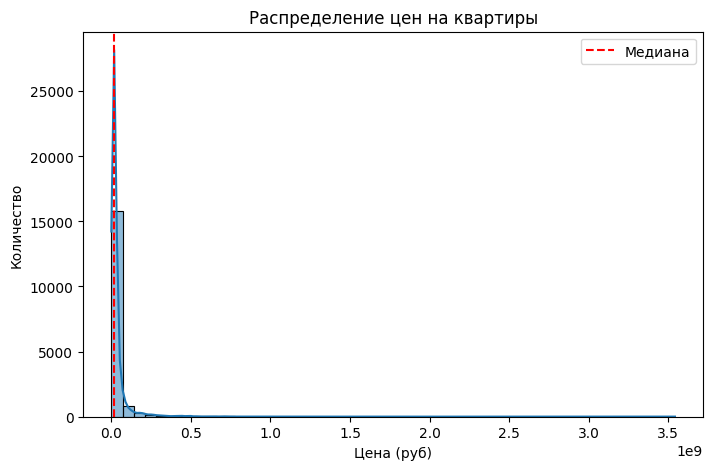

In [15]:
print('Максимальная и минимальная цены на квартиру:')
print(max(ds_full['price']), min(ds_full['price']))

plt.figure(figsize=(8, 5))
sns.histplot(ds_full['price'], bins=50, kde=True)
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена (руб)')
plt.ylabel('Количество')
plt.axvline(x=ds_full['price'].median(), color='r', linestyle='--', label='Медиана')
plt.legend()
plt.show();

In [16]:
low = ds_full['price'].quantile(0.05)
high = ds_full['price'].quantile(0.95)
anomalies = ds_full[((ds_full['price'] < low) | (ds_full['price'] > high))].index
print(f'{len(anomalies)} "price" anomalies in dataset')
ds_full.drop(anomalies, inplace=True)
ds_full.reset_index()
print(len(ds_full))

1714 "price" anomalies in dataset
15535


In [17]:
object_cols = [col for col in ds_full.columns if ds_full[col].dtype == 'O']

for col in object_cols:
    ds_full[col] = ds_full[col].apply(lambda x: str(x).lower() if pd.notnull(x) else 'unknown')
    
print('Missing values after processing:')
print(ds_full[object_cols].isna().sum())

Missing values after processing:
dealType           0
repairType         0
hasFurniture       0
isApartments       0
flatType           0
windowsViewType    0
hasLift            0
materialType       0
dtype: int64


In [18]:
ds_full['balconiesCount'] = ds_full['balconiesCount'].fillna(0)

build_year_median = ds_full['buildYear'].median()
ds_full['buildYear'] = ds_full['buildYear'].fillna(build_year_median)

living_area_median = ds_full['livingArea'].median()
ds_full['livingArea'] = ds_full['livingArea'].fillna(living_area_median)

kitchen_area_median = ds_full['kitchenArea'].median()
ds_full['kitchenArea'] = ds_full['kitchenArea'].fillna(kitchen_area_median)

total_area_median = ds_full['totalArea'].median()
ds_full['totalArea'] = ds_full['totalArea'].fillna(total_area_median)

In [19]:
ds_full.describe()

,roomsCount,floorNumber,livingArea,balconiesCount,kitchenArea,totalArea,buildYear,distance_to_center,highways_count,undergrounds_count,railways_count,price
count,15535.000000,15535.000000,15535.000000,15535.000000,15535.000000,15535.000000,15535.000000,15535.000000,15535.000000,15535.000000,15535.000000,1.553500e+04
mean,2.168265,9.120566,34.140953,0.309108,11.787184,62.750877,1995.978758,13.168023,0.530222,3.332282,6.033473,2.445435e+07
std,0.922731,7.629966,17.165699,0.529402,6.097341,29.379811,21.482335,6.854898,0.873319,1.294698,0.504811,1.850379e+07
min,1.000000,-2.000000,1.000000,0.000000,1.800000,13.200000,1820.000000,0.610492,0.000000,0.000000,0.000000,7.900000e+06
25%,1.000000,4.000000,23.900000,0.000000,8.000000,42.400000,1984.000000,8.133540,0.000000,3.000000,6.000000,1.280000e+07
50%,2.000000,7.000000,31.000000,0.000000,10.000000,56.600000,2001.000000,12.608742,0.000000,3.000000,6.000000,1.795000e+07
75%,3.000000,13.000000,40.000000,1.000000,14.000000,74.100000,2009.000000,17.121567,2.000000,3.000000,6.000000,2.800000e+07
max,5.000000,84.000000,412.000000,4.000000,100.000000,584.100000,2029.000000,40.790599,2.000000,15.000000,12.000000,1.150000e+08


In [20]:
# затычка, чтобы копировать прошлый код не меняя названия переменных
selected_ds = ds_full.copy()
selected_ds.columns

Index(['dealType', 'roomsCount', 'repairType', 'hasFurniture', 'isApartments',
       'floorNumber', 'flatType', 'livingArea', 'windowsViewType',
       'balconiesCount', 'kitchenArea', 'isRecidivist', 'totalArea', 'hasLift',
       'buildYear', 'materialType', 'distance_to_center', 'highways_count',
       'undergrounds_count', 'railways_count', 'price'],
      dtype='object')

In [21]:
# adding new features for high correlated pairs
# rooms_count and total_meters ; floors_count and floor
# selected_ds['area_per_room'] = selected_ds['livingArea'] / selected_ds['roomsCount']
# selected_ds['floor_ratio'] = selected_ds['floor'] / selected_ds['floors_count']

In [22]:
X, y = selected_ds.drop(['price'], axis=1), selected_ds['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=my_seed)
print(len(X_train), len(X_test), len(y_train), len(y_test))

12428 3107 12428 3107


In [23]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# high cardinality in some columns
sorted(d.items(), key=lambda x: x[1])

[('dealType', 1),
 ('flatType', 1),
 ('hasFurniture', 3),
 ('isApartments', 3),
 ('hasLift', 3),
 ('windowsViewType', 4),
 ('repairType', 5),
 ('materialType', 9)]

In [24]:
# target encoding for high cardinality
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 20]
print(low_cardinality_cols)
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))
print(high_cardinality_cols)

encoder = TargetEncoder(cols=high_cardinality_cols, smoothing=10.0)

X_train_encoded = encoder.fit_transform(X_train[high_cardinality_cols], y_train)
X_test_encoded = encoder.transform(X_test[high_cardinality_cols])

X_train = pd.concat([X_train.drop(high_cardinality_cols, axis=1), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(high_cardinality_cols, axis=1), X_test_encoded], axis=1)

['dealType', 'repairType', 'hasFurniture', 'isApartments', 'flatType', 'windowsViewType', 'hasLift', 'materialType']
[]


In [25]:
numeric_cols = [col for col in X_train.columns if (X_train[col].dtype in ['int64', 'float64', 'int32', 'float32'])]
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [26]:
# ohe encoding for low cardinality

ohe_encoding = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
for col in low_cardinality_cols:
    ohe_cats_array = ohe_encoding.fit_transform(X_train[[col]])
    ohe_cats_df = pd.DataFrame(ohe_cats_array, 
                               columns=[f"{col}_{cat}" for cat in ohe_encoding.categories_[0]],
                               index=X_train.index)
    X_train = pd.concat([X_train, ohe_cats_df], axis=1).drop([col], axis=1)

    ohe_test_cats_array = ohe_encoding.transform(X_test[[col]])
    ohe_test_cats_df = pd.DataFrame(ohe_test_cats_array, 
                                    columns=[f"{col}_{cat}" for cat in ohe_encoding.categories_[0]],
                                    index=X_test.index)
    
    X_test = pd.concat([X_test, ohe_test_cats_df], axis=1).drop([col], axis=1)

X_train.head()

,roomsCount,floorNumber,livingArea,balconiesCount,kitchenArea,isRecidivist,totalArea,buildYear,distance_to_center,highways_count,...,hasLift_unknown,materialType_block,materialType_brick,materialType_monolith,materialType_monolithbrick,materialType_panel,materialType_stalin,materialType_unknown,materialType_wireframe,materialType_wood
1599,1.981532,-0.938211,1.909909,1.298154,1.352561,False,1.209440,0.238637,-0.267764,-0.604381,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10848,-0.185052,-0.545333,-0.307038,1.298154,-0.946257,False,-0.636748,0.238637,-0.293002,-0.604381,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5963,0.898240,-0.152456,0.903296,-0.583738,-0.289452,False,0.543714,1.076586,0.258287,-0.604381,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4574,-0.185052,1.026178,-0.007450,-0.583738,0.203152,False,-0.087696,0.657611,0.099529,-0.604381,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15291,-0.185052,-0.021496,-0.187203,-0.583738,-0.617854,False,-0.430854,-0.645865,-0.054502,-0.604381,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
def save_splits_prefix(prefix):    
    X_train.to_pickle(f'x_train{prefix}.pkl') 
    y_train.to_pickle(f'y_train{prefix}.pkl') 
    X_test.to_pickle(f'x_test{prefix}.pkl') 
    y_test.to_pickle(f'y_test{prefix}.pkl') 

save_splits_prefix('_big_mosc_0506')

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


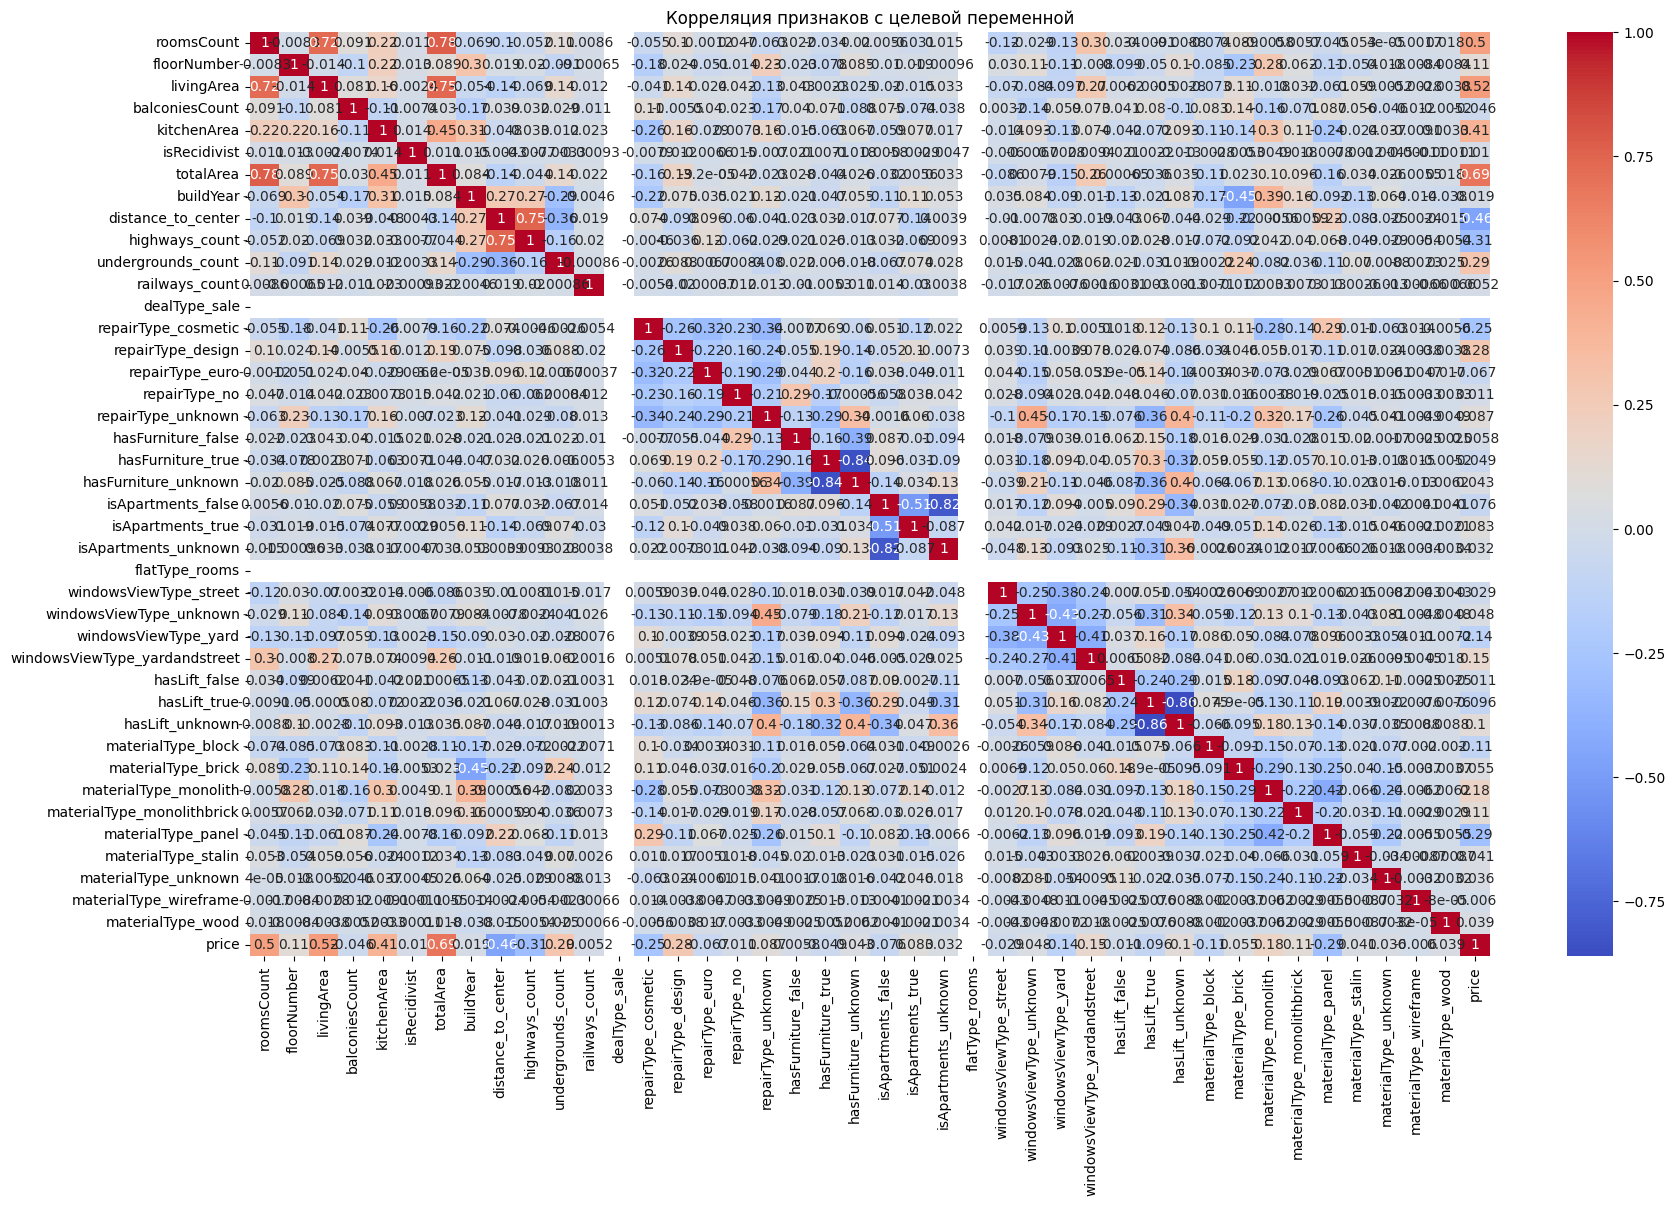

In [28]:
corr_matrix = X_train.join(y_train).corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляция признаков с целевой переменной')
plt.show()

In [29]:
model = CatBoostRegressor()
model.fit(X_train, y_train, verbose=100)

Learning rate set to 0.060967
0:	learn: 17819338.4040558	total: 58.8ms	remaining: 58.7s
100:	learn: 7692962.9686302	total: 389ms	remaining: 3.46s
200:	learn: 7078017.0792743	total: 740ms	remaining: 2.94s
300:	learn: 6606099.4518193	total: 1.15s	remaining: 2.66s
400:	learn: 6250087.7287225	total: 1.52s	remaining: 2.28s
500:	learn: 5956690.3892893	total: 1.85s	remaining: 1.84s
600:	learn: 5708873.9942676	total: 2.16s	remaining: 1.44s
700:	learn: 5505373.2425395	total: 2.48s	remaining: 1.06s
800:	learn: 5322454.8936717	total: 2.79s	remaining: 693ms
900:	learn: 5143010.5855967	total: 3.11s	remaining: 342ms
999:	learn: 4983311.8934788	total: 3.45s	remaining: 0us


In [30]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error (RMSE):", mse**0.5)
print("R² Score:", r2)

Root Mean Squared Error (RMSE): 7568001.412226575
R² Score: 0.8297119764707372


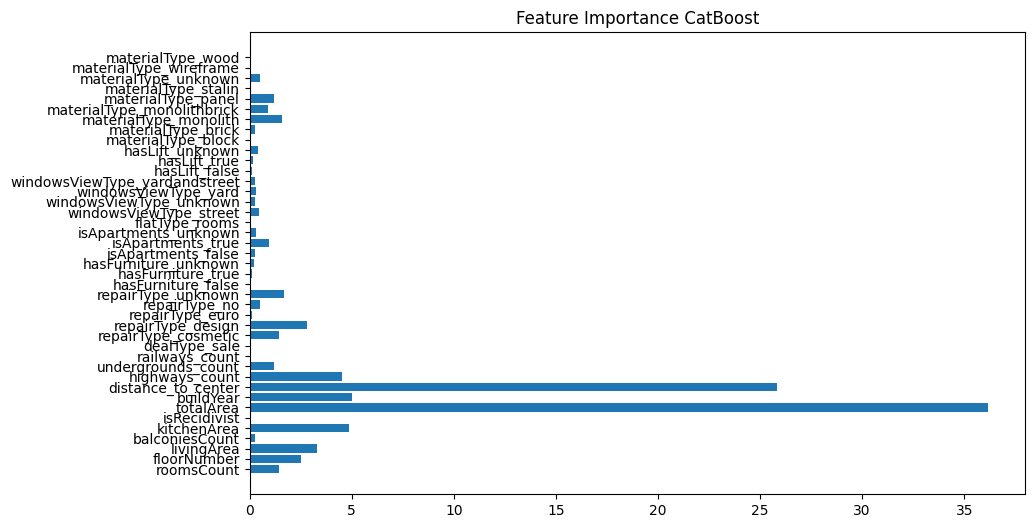

In [31]:
feature_importance = model.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importance)
plt.title('Feature Importance CatBoost')
plt.show()